# Sentiment Analysis using BERT



## 1. Importar librerias y carga del dataset

<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRN2jcdU6dDNGTlHEmVIl_-FzSXAaGfJ2cJyQ&s" width="400" height="200">

### 1.1. Importar librerias

In [1]:
# !pip install datasets accelerate

In [2]:
# Essentials libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# NLP libraries
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### 1.2. Descomprimir el zip

In [3]:
import zipfile
import os

zip_file_path = '/content/nlp-sentiment-analysis-xm.zip'
output_folder = '/content/dataset'

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(output_folder)

### 1.3. Carga del dataset

In [4]:
train = pd.read_csv("/content/dataset/train.csv")
test = pd.read_csv("/content/dataset/test_features.csv")

## 2. AnÃ¡lisis Exploratorio de los datos
<img src="https://d2o2utebsixu4k.cloudfront.net/media/images/3a2daf59-b87d-453e-871c-070e4656267e.jpg" width="400" height="200">

In [5]:
train.info()
print("\n")
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        1600 non-null   int64 
 1   Text      1600 non-null   object
 2   Category  1600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 37.6+ KB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      400 non-null    int64 
 1   Text    400 non-null    object
dtypes: int64(1), object(1)
memory usage: 6.4+ KB


In [6]:
train.describe()

ID     Category
count  1600.000000  1600.000000
mean    997.376875     1.504375
std     574.166552     1.117256
min       1.000000     0.000000
25%     504.750000     1.000000
50%     999.500000     1.000000
75%    1483.500000     3.000000
max    2000.000000     3.000000

In [7]:
train.shape

(1600, 3)

In [8]:
train['Category'].value_counts()

Category
1    409
3    404
0    394
2    393
Name: count, dtype: int64

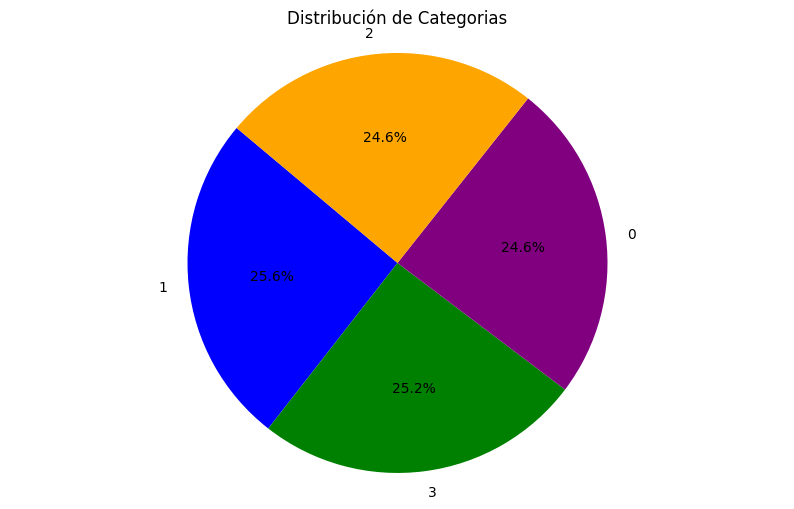

In [9]:
labels = train["Category"].value_counts().index
counts = train["Category"].value_counts().values

plt.figure(figsize=(10,6))
plt.pie(counts, labels=labels, autopct="%1.1f%%", startangle=140, colors=['blue', 'green', 'purple', 'orange', 'red', 'gray'])
plt.title("DistribuciÃ³n de categorÃ­as")
plt.axis("equal")
plt.show()

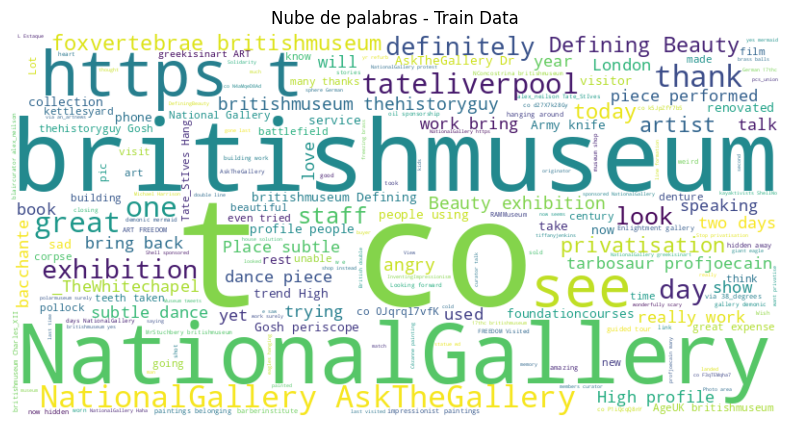

In [127]:
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(train['Text'].tolist()))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Nube de palabras - Train Data")
plt.axis('off')
plt.show()

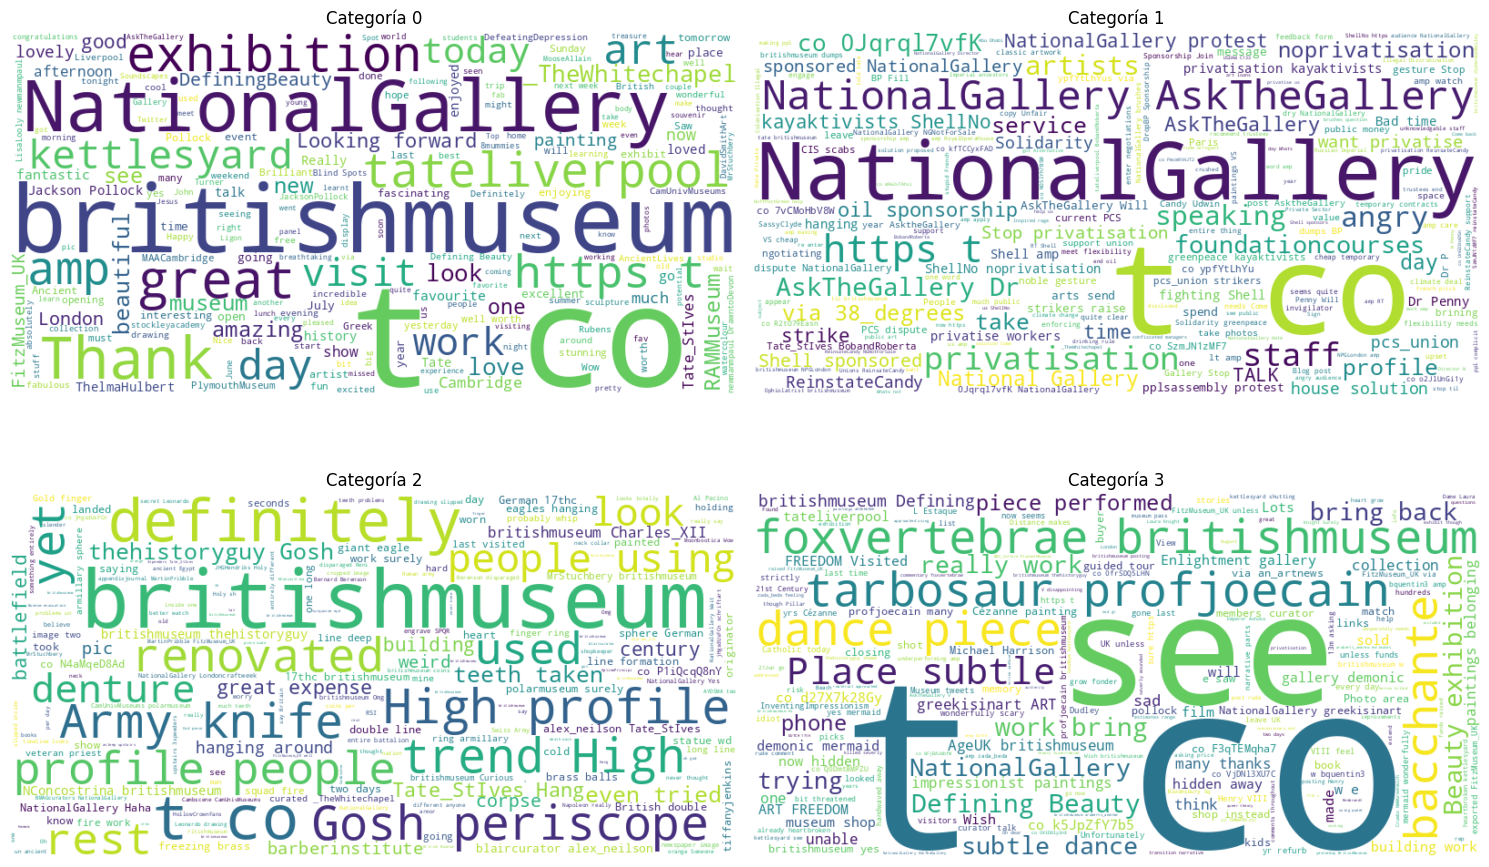

In [11]:
wordcloud1 = WordCloud(width=800, height=400, background_color='white').generate(" ".join(train[train['Category'] == 0]['Text'].tolist()))
wordcloud2 = WordCloud(width=800, height=400, background_color='white').generate(" ".join(train[train['Category'] == 1]['Text'].tolist()))
wordcloud3 = WordCloud(width=800, height=400, background_color='white').generate(" ".join(train[train['Category'] == 2]['Text'].tolist()))
wordcloud4 = WordCloud(width=800, height=400, background_color='white').generate(" ".join(train[train['Category'] == 3]['Text'].tolist()))

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

axs[0, 0].imshow(wordcloud1, interpolation='bilinear')
axs[0, 0].set_title("Category 0")
axs[0, 0].axis('off')

axs[0, 1].imshow(wordcloud2, interpolation='bilinear')
axs[0, 1].set_title("Category 1")
axs[0, 1].axis('off')

axs[1, 0].imshow(wordcloud3, interpolation='bilinear')
axs[1, 0].set_title("Category 2")
axs[1, 0].axis('off')

axs[1, 1].imshow(wordcloud4, interpolation='bilinear')
axs[1, 1].set_title("Category 3")
axs[1, 1].axis('off')

plt.tight_layout()
plt.show()

## 3. Limpieza de los datos (Preprocesamiento)
<img src="https://miro.medium.com/v2/resize:fit:1400/1*aDiW2KddpHmTF3uAiibTCQ.png" width="400" height="200">

In [12]:
train_duplicated = train[train.duplicated("Text")]["Text"].to_list()
len(train_duplicated)

0

In [87]:
def clean_data(text):
  text = re.sub(r'http\S+', '', text)
  text = re.sub(r'[@#$&!]', ' ', text)
  text = re.sub(r'@[A-Za-z0-9_]+', '', text)
  text = re.sub(r'\s+', ' ', text)

  text = text.lower()
  tokens = word_tokenize(text)

  stop_words = set(stopwords.words('english')) - {'not', 'no', 'nor'}
  tokens = [token for token in tokens if token not in stop_words]

  lemmatizer = WordNetLemmatizer()
  tokens = [lemmatizer.lemmatize(token) for token in tokens]

  text = ' '.join(tokens)
  return text

In [88]:
train['clean_text'] = train['Text'].apply(clean_data)
test['clean_text'] = test['Text'].apply(clean_data)

In [89]:
train.head(20)

ID                                               Text  Category  \
0    969  @JuliaBradbury @SimonCalder @walsop @HodderPRI...         0   
1    241  or here https://t.co/R2tO79Easn â€¦ .An in house...         1   
2    820  @britshmuseum @thehistoryguy Gosh periscope is...         2   
3    693  @Ophiolatrist britishmuseum The stupid #French...         1   
4    421  @SassyClde We won't stop til @britishmuseum du...         1   
5   1086  @tateliverpool Member's Preview of #JacksonPol...         0   
6   1999  @britishuseum How did the British double line ...         2   
7    366  James Richards extraordinary instln @_TheWhite...         0   
8   1023  300 miles to see art? In this case it might be...         0   
9   1241  @NationalGallery favourite summer art is Seura...         0   
10   589  Enjoyed the excellent artist talk by Glen Ligo...         0   
11   737  Found this yesterday @BritishMuseum - desperat...         3   
12  1762  @NationalGallery @pcs_union strikers raise Â£1,...         1   
13   942  @britishmuseum @Moobootica Wow, he was a very ...         2   
14    72  Good to see you yesterday &amp; all the work i...         0   
15  1408  This w/e saw te closing of @kettlesyard for bu...         3   
16   260  British Museum evacuation?! @britishmuseum #br...         2   
17    52  Excited about Castle Hill Open Day tomorrow @k...         0   
18   199  GO visit @Sothebys or @ChristiesInc &amp; take...         1   
19  1789  at the @NationalGallery . the#InventingImpress...         3   

                                           clean_text  
0   juliabradbury simoncalder walsop hodderpriba _...  
1   â€¦ .an house solutio proposed meet flexibility ...  
2   britshmuseum thehistoryguy gosh periscope defi...  
3   ophiolatrist britishmuseum stupid french prick...  
4   sassyclde wo n't stop til britishmuseum dump b...  
5   tateliverpool member 's preview jacksonpollock...  
6   britishuseum british double line formation squ...  
7   james richards extraordinary instln _thewhitec...  
8   300 mile see art ? case might worth . tatelive...  
9   nationalgallery favourite summer art seurat , ...  
10  enjoyed excellent artist talk glen ligon . tat...  
11  found yesterday britishmuseum - desperately ne...  
12  nationalgallery pcs_union striker raise Â£1,000...  
13            britishmuseum moobootica wow , old 32 .  
14  good see yesterday amp ; work progress flockto...  
15  w/e saw te closing kettlesyard building work ;...  
16  british museum evacuation ? britishmuseum brii...  
17  excited castle hill open day tomorrow kettlesy...  
18  go visit sothebys christiesinc amp ; take phot...  
19  nationalgallery . inventingimpressionism stric...

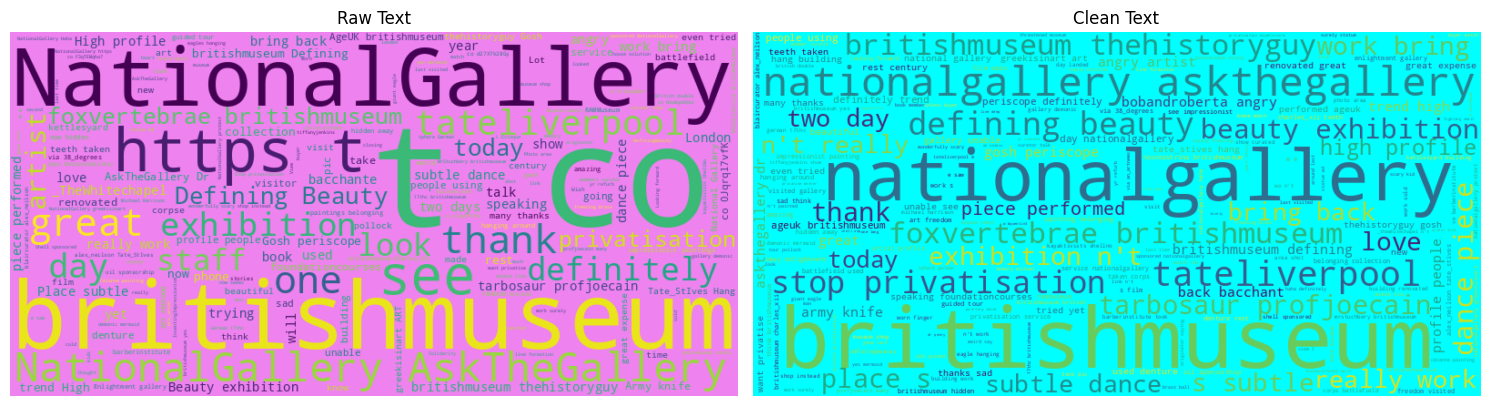

In [128]:
wordcloud_text = WordCloud(width=800, height=400, background_color='violet').generate(" ".join(train['Text'].tolist()))
wordcloud_clean_text = WordCloud(width=800, height=400, background_color='cyan').generate(" ".join(train['clean_text'].tolist()))

fig, axs = plt.subplots(1, 2, figsize=(15, 10))

axs[0].imshow(wordcloud_text, interpolation='bilinear')
axs[0].set_title("Raw Text")
axs[0].axis('off')

axs[1].imshow(wordcloud_clean_text, interpolation='bilinear')
axs[1].set_title("Clean Text")
axs[1].axis('off')


plt.tight_layout()
plt.show()

## 4. SelecciÃ³n y entrenamiento del Modelo
<img src="https://sushant-kumar.com/blog/bert-architecture.png" width="400" height="200">

In [90]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig
from transformers import Trainer, TrainingArguments, DataCollatorWithPadding

tokenizer_bert = BertTokenizer.from_pretrained('google-bert/bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [91]:
from datasets import Dataset
dataset = Dataset.from_pandas(train)
dataset = dataset.rename_column("clean_text", "text")
dataset = dataset.rename_column("Category", "label")
dataset[1]

{'ID': 241,
 'Text': "or here https://t.co/R2tO79Easn â€¦ .An in house solutio proposed to meet flexibility needs. Come on @NationalGallery - it's time to TALK.",
 'label': 1,
 'text': "â€¦ .an house solutio proposed meet flexibility need . come nationalgallery - 's time talk ."}

In [92]:
def tokenize_bert_function(samples):
    return tokenizer_bert(samples['text'], padding='max_length', truncation=True, max_length=128, return_tensors='pt')

In [93]:
tokenized_datasets_bert = dataset.map(tokenize_bert_function, batched=True)

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

In [94]:
train_bert_test_split = tokenized_datasets_bert.train_test_split(test_size=0.2)
train_bert = train_bert_test_split['train']
test_bert = train_bert_test_split['test']

In [95]:
model_bert = BertForSequenceClassification.from_pretrained('google-bert/bert-base-uncased', num_labels=4)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model_bert.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [96]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    learning_rate=5e-5,
)
model_bert.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of ðŸ¤— Transformers. Use `eval_strategy` instead
  warnings.warn(


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [97]:
trainer_bert = Trainer(
    model=model_bert,
    args=training_args,
    train_dataset=train_bert,
    eval_dataset=test_bert
)
trainer_bert.train()

TrainOutput(global_step=120, training_loss=0.36478872299194337, metrics={'train_runtime': 92.2876, 'train_samples_per_second': 41.609, 'train_steps_per_second': 1.3, 'total_flos': 252591148892160.0, 'train_loss': 0.36478872299194337, 'epoch': 3.0})

In [98]:
trainer_bert.evaluate()

{'eval_loss': 0.03135037049651146,
 'eval_runtime': 2.1158,
 'eval_samples_per_second': 151.241,
 'eval_steps_per_second': 4.726,
 'epoch': 3.0}

In [99]:
model_bert.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [102]:
model_bert.save_pretrained("./saved_model")
tokenizer_bert.save_pretrained("./saved_model")

('./saved_model/tokenizer_config.json',
 './saved_model/special_tokens_map.json',
 './saved_model/vocab.txt',
 './saved_model/added_tokens.json')

In [103]:
!zip -r saved_model.zip saved_model

  adding: saved_model/ (stored 0%)
  adding: saved_model/special_tokens_map.json (deflated 42%)
  adding: saved_model/config.json (deflated 52%)
  adding: saved_model/model.safetensors (deflated 7%)
  adding: saved_model/tokenizer_config.json (deflated 75%)
  adding: saved_model/vocab.txt (deflated 53%)


## 5. Metricas de EvaluaciÃ³n del Modelo
<img src="https://miro.medium.com/v2/resize:fit:940/1*dbArqIcAHxMmZDONLdTG1A.png" width="400" height="200">

In [129]:
from sklearn.metrics import classification_report

predictions_bert = trainer_bert.predict(test_bert)

In [130]:
print("BERT:\n", classification_report(test_bert['label'], predictions_bert.predictions.argmax(-1)))

BERT:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98        82
           1       0.98      0.99      0.98        85
           2       0.99      1.00      0.99        76
           3       0.99      1.00      0.99        77

    accuracy                           0.99       320
   macro avg       0.99      0.99      0.99       320
weighted avg       0.99      0.99      0.99       320



In [131]:
test

ID                                               Text  \
0    1861  Goodbye @kettlesyard see you in .25 years! htt...   
1     354  @BBC_Culture @PlymouthMuseum Oh dear, why not ...   
2    1334  Fantastic @johnmcdonnellMP standing up for wor...   
3     906  @BBC_Culture @PlymouthMuseum Oh dear, why not ...   
4    1290                @britishmuseum @TripAdvisor it is !   
..    ...                                                ...   
395   966  Unfortunately the transition narrative parts o...   
396  1285  #AskTheGallery Love @NationalGallery. Hate Pri...   
397  1740  @CelesteRegal Well, I hope so - but I don't su...   
398   262  @tateliverpool I'm trying to book the members ...   
399   536  Found this yesterday @BritishMuseum - desperat...   

                                            clean_text  predicted_sentiment  \
0                     goodbye kettlesyard see .25 year                    3   
1    bbc_culture plymouthmuseum oh dear , not dame ...                    3   
2    fantastic johnmcdonnellmp standing worker nati...                    1   
3    bbc_culture plymouthmuseum oh dear , not dame ...                    3   
4                            britishmuseum tripadvisor                    0   
..                                                 ...                  ...   
395  unfortunately transition narrative part story ...                    3   
396  askthegallery love nationalgallery . hate priv...                    1   
397  celesteregal well , hope - n't suppose tha 'll...                    3   
398  tateliverpool 'm trying book member curator ta...                    3   
399  found yesterday britishmuseum - desperately ne...                    3   

     Prediction  
0             3  
1             3  
2             1  
3             3  
4             0  
..          ...  
395           3  
396           1  
397           3  
398           3  
399           3  

[400 rows x 5 columns]

### Submission

In [132]:
model_path = './saved_model'

tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertForSequenceClassification.from_pretrained(model_path)

def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128)

    with torch.no_grad():
        outputs = model(**inputs)

    predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
    predicted_class = predictions.argmax().item()

    return predicted_class

In [134]:
test['Prediction'] = test['clean_text'].apply(predict_sentiment)

In [135]:
test.head()

ID                                               Text  \
0  1861  Goodbye @kettlesyard see you in .25 years! htt...   
1   354  @BBC_Culture @PlymouthMuseum Oh dear, why not ...   
2  1334  Fantastic @johnmcdonnellMP standing up for wor...   
3   906  @BBC_Culture @PlymouthMuseum Oh dear, why not ...   
4  1290                @britishmuseum @TripAdvisor it is !   

                                          clean_text  predicted_sentiment  \
0                   goodbye kettlesyard see .25 year                    3   
1  bbc_culture plymouthmuseum oh dear , not dame ...                    3   
2  fantastic johnmcdonnellmp standing worker nati...                    1   
3  bbc_culture plymouthmuseum oh dear , not dame ...                    3   
4                          britishmuseum tripadvisor                    0   

   Prediction  
0           3  
1           3  
2           1  
3           3  
4           0

In [136]:
submission_data = test[['ID', 'Prediction']]
submission_data.to_csv('submission.csv', index=False)

## 6. Conclusiones

<img src="https://img.freepik.com/premium-vector/businessman-writes-conclusion-report-concept-paperwork-sheets-folder-holding-clipboard-pen-hand-finally-outcome-result-vector-illustration-flat-design-isolated-background_153097-169.jpg" width="400" height="200">

Se utilizÃ³ un dataset de Kaggle

### References

1. https://arxiv.org/abs/1706.03762
2. https://arxiv.org/abs/1810.04805
3. https://www.kaggle.com/competitions/nlp-sentiment-analysis-xm/overview